<a href="https://colab.research.google.com/github/wilbertcaine/COMP4211/blob/main/Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# https://drive.google.com/file/d/199mVXHt5cxT68gBXCcucMjtJzCwvc8ud/view?usp=sharing
# https://drive.google.com/file/d/1d2hJyvo2Go4FxK7br0exFQFdZ1eCexIA/view?usp=sharing
# https://drive.google.com/file/d/1yjsMICWqHdEUhF758ndq0hLO96FrYWkR/view?usp=sharing
%cd /content
!mkdir -p dataset
%cd /content/dataset
!gdown --id 199mVXHt5cxT68gBXCcucMjtJzCwvc8ud
!gdown --id 1d2hJyvo2Go4FxK7br0exFQFdZ1eCexIA
!gdown --id 1yjsMICWqHdEUhF758ndq0hLO96FrYWkR
%cd ../

/content
/content/dataset
Downloading...
From: https://drive.google.com/uc?id=199mVXHt5cxT68gBXCcucMjtJzCwvc8ud
To: /content/dataset/train.csv
100% 7.62M/7.62M [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d2hJyvo2Go4FxK7br0exFQFdZ1eCexIA
To: /content/dataset/Test_Jan.csv
100% 124k/124k [00:00<00:00, 45.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yjsMICWqHdEUhF758ndq0hLO96FrYWkR
To: /content/dataset/Predict_Jan.csv
100% 20.7k/20.7k [00:00<00:00, 35.0MB/s]
/content


In [ ]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

!pip install torchsummaryX

import matplotlib.pyplot as plt
import os.path as osp
from torchsummaryX import summary
from torch.utils.tensorboard import SummaryWriter
import random

In [ ]:
def train_epoch(net, optimizer, loss_fn, dataloader, epoch, train_size, writer=None, device='cpu'):
    ep_loss = 0.0
    num_iter = len(dataloader)
    net.train()
    grad_max = 100.
    for n_iter, (xs, y) in enumerate(dataloader):
        curr_iter = epoch * num_iter + n_iter
        xs, y = xs.to(device), y.to(device)
        pred = net(xs) ## step 1. get output
        loss = loss_fn(pred, y) ## step 2. compute loss
        optimizer.zero_grad()
        loss.backward() ## step 3. backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), grad_max) ## L2-norm gradient clipping
        optimizer.step() ## step 4. update model weigth
        if writer is not None:
            writer.add_scalar('Loss/train', loss.data, curr_iter)
        # print("\n[ITER %d] LOSS: %.4f" % (curr_iter, loss.data))
        ep_loss += loss.data
        if n_iter + 1 == train_size:
            break
    ep_loss /= train_size
    if writer is not None:
        writer.add_scalar('EpLoss/train', ep_loss, epoch)
    return ep_loss

@torch.no_grad()
def val_epoch(net, loss_fn, dataloader, epoch, val_set, writer=None, device='cpu'):
    ep_loss = 0.0
    net.eval()
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(dataloader):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
    ep_loss /= len(dataloader)

    if writer is not None:
        writer.add_scalar('EpLoss/val', ep_loss, epoch)
    return ep_loss

def train(net, train_set, val_set, loss_fn, batch_size, lr, n_epoch, train_size, name='net'):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1)

    save_dir = f'drive/MyDrive/COMP4211/project/logs/{name}_{batch_size}_{lr}'
    writer = SummaryWriter(log_dir=osp.join(save_dir, 'log'))
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    train_ep_losses, val_ep_losses = [], []
    min_loss = 0
    argmin_loss = 0
    for epoch in range(n_epoch):
        train_loss = train_epoch(net, optimizer, loss_fn, train_loader, epoch, train_size, writer, device)
        val_loss = val_epoch(net, loss_fn, val_loader, epoch, val_set, writer, device)
        train_ep_losses.append(train_loss)
        val_ep_losses.append(val_loss)
        if (epoch + 1) % 5 == 0:
            print("[EP \t%d] \t\tTrain LOSS: \t%.4f \t\tVal LOSS: \t%.4f" % (epoch + 1, train_loss, val_loss))
            os.makedirs(osp.join(save_dir, 'weights'), exist_ok=True)
            torch.save(net.state_dict(), osp.join(save_dir, 'weights/ep%d.pth' % (epoch + 1)))
            if argmin_loss == 0:
                min_loss = val_loss
            if min_loss >= val_loss:
                min_loss = val_loss
                argmin_loss = epoch + 1
    
    plt.plot(torch.tensor(train_ep_losses).cpu().numpy(), label='train')
    plt.plot(torch.tensor(val_ep_losses).cpu().numpy(), label='val')
    plt.xlabel('n_epoch')
    plt.legend()
    plt.show()
    return argmin_loss

@torch.no_grad()
def test(net, loss_fn, test_data, batch_size, lr, epoch=90, name='net'):
    net.eval()
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    save_dir = f'drive/MyDrive/COMP4211/project/logs/{name}_{batch_size}_{lr}'
    net.load_state_dict(torch.load(osp.join(save_dir, 'weights/ep%d.pth' % epoch)))
    test_loader = DataLoader(test_set, batch_size=1)
    ep_loss = 0.0
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(test_loader):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
    ep_loss /= len(test_loader)
    return ep_loss

# Prev

In [ ]:
df = pd.read_csv('dataset/train.csv')
df = df['nat_demand']
data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
curr = np.array(data[2][1:])
prev = np.array(data[2][:-1])
dist = np.linalg.norm(curr-prev, ord=1)/len(curr)
print(dist)

46.833183216570205


# FC_Net

In [ ]:
class FC_Net_Dataset(Dataset):
    def __init__(self, split, eval_len=1, csv_dir='dataset/train.csv'):
        """
        Keyword arguments:
        split -- an integer either 0, 1, or 2 which indicates train, validation, or test respectively
        eval_len -- an integer indicating the number of future timestamp to be predicted
        """
        super(FC_Net_Dataset, self).__init__()
        df = pd.read_csv(csv_dir)
        df['datetime']=pd.to_datetime(df['datetime'])
        df['week_day']=df['datetime'].dt.dayofweek
        df['hour']=df['datetime'].dt.hour
        df = df.drop(columns="datetime")
        data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
        self.data = np.array(data[split])
        self.eval_len = eval_len

    def __getitem__(self, idx):
        idx = np.random.randint(1, len(self.data)-1 - self.eval_len)
        prev_nat_demand = np.reshape(self.data[idx-1][0], -1)
        curr_feat = np.concatenate((prev_nat_demand, self.data[idx][1:]))
        curr_nat_demand = np.reshape(self.data[idx][0], -1)
        return curr_feat, curr_nat_demand

    def __len__(self):
        return len(self.data)

In [ ]:
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net, self).__init__()

        self.fc1 = nn.Linear(18, 32)
        self.fc2 = nn.Linear(32, 32)
        self.bn1 = nn.BatchNorm1d(32, affine=True)
        self.fc3 = nn.Linear(32, 8)
        self.bn2 = nn.BatchNorm1d(8, affine=True)
        self.fc4 = nn.Linear(8, 1)
        self.relu = nn.ReLU(inplace=True)
 
    def forward(self, x):
        x = x.float()

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.relu(x)
        
        return x

[EP 	5] 		Train LOSS: 	1097.6449 		Val LOSS: 	1148.1635
[EP 	10] 		Train LOSS: 	935.3331 		Val LOSS: 	981.3541
[EP 	15] 		Train LOSS: 	703.5209 		Val LOSS: 	743.7540
[EP 	20] 		Train LOSS: 	474.0166 		Val LOSS: 	636.7478
[EP 	25] 		Train LOSS: 	340.1242 		Val LOSS: 	399.3645
[EP 	30] 		Train LOSS: 	244.2387 		Val LOSS: 	273.1899
[EP 	35] 		Train LOSS: 	188.4012 		Val LOSS: 	281.6482
[EP 	40] 		Train LOSS: 	100.7179 		Val LOSS: 	112.0434
[EP 	45] 		Train LOSS: 	50.9488 		Val LOSS: 	48.1492
[EP 	50] 		Train LOSS: 	41.7500 		Val LOSS: 	63.8305
[EP 	55] 		Train LOSS: 	38.6633 		Val LOSS: 	80.0395
[EP 	60] 		Train LOSS: 	39.0001 		Val LOSS: 	33.2816
[EP 	65] 		Train LOSS: 	36.7154 		Val LOSS: 	74.2676
[EP 	70] 		Train LOSS: 	34.6081 		Val LOSS: 	35.3237
[EP 	75] 		Train LOSS: 	34.2986 		Val LOSS: 	44.2238
[EP 	80] 		Train LOSS: 	33.3486 		Val LOSS: 	31.4914
[EP 	85] 		Train LOSS: 	33.9585 		Val LOSS: 	46.6778
[EP 	90] 		Train LOSS: 	33.7136 		Val LOSS: 	41.6839
[EP 	95] 		Train LOSS: 	32.98

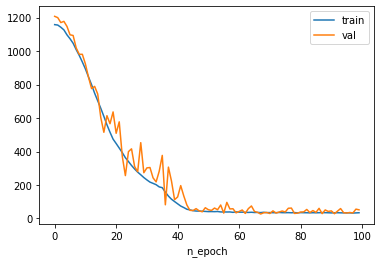

In [ ]:
train_set = FC_Net_Dataset(split=0)
val_set = FC_Net_Dataset(split=1)

np.random.seed(1)
fc_net = FC_Net();
loss_fn = nn.L1Loss()
batch_size, n_epoch, lr = 32, 100, 1e-3
train_size, val_size = 365, 365
argmin_loss = train(fc_net, train_set, val_set, loss_fn, batch_size, lr, n_epoch, train_size, name='fc_net')

In [ ]:
net = FC_Net()
test_set = FC_Net_Dataset(split=2)
test_loss = test(net, loss_fn, test_set, batch_size, lr, epoch=argmin_loss, name='fc_net')
print("Test LOSS: \t%.4f" % (test_loss))

Test LOSS: 	28.3152


# R_Net

In [34]:
class R_Net_Dataset(Dataset):
    def __init__(self, split, eval_len=1, window_size=5, csv_dir='dataset/train.csv'):
        """
        Keyword arguments:
        split -- an integer either 0, 1, or 2 which indicates train, validation, or test respectively
        eval_len -- an integer indicating the number of future timestamp to be predicted
        """
        super(R_Net_Dataset, self).__init__()
        df = pd.read_csv(csv_dir)
        df['datetime']=pd.to_datetime(df['datetime'])
        df['week_day']=df['datetime'].dt.dayofweek
        # df['date']=df['datetime'].dt.day
        # df['month']=df['datetime'].dt.month
        df['hour']=df['datetime'].dt.hour
        df = df.drop(columns="datetime")
        data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
        self.data = np.array(data[split])
        self.eval_len = eval_len
        self.window_size = window_size

    def __getitem__(self, idx):
        min_start = self.window_size+1
        max_start = len(self.data)-1 - self.eval_len
        idx = np.random.randint(min_start, max_start)
        prev_nat_demand = np.reshape(self.data[idx-1 - self.window_size: idx-1, 0], (-1,1))
        curr_feat = np.concatenate((prev_nat_demand, self.data[idx - self.window_size: idx, 1:]), axis=1)
        curr_nat_demand = np.reshape(self.data[idx, 0], -1)
        return curr_feat, curr_nat_demand

    def __len__(self):
        return len(self.data)

In [44]:
class R_Net(nn.Module):
    def __init__(self, input_size=18, hidden_size=32, dropout=0, num_layers=1, skip=False):
        super(R_Net, self).__init__()

        self.bn1 = nn.BatchNorm1d(input_size, affine=True)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.skip = skip
        if self.skip:
            self.fc1 = nn.Linear(18+hidden_size, 32)
        else:
            self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.bn2 = nn.BatchNorm1d(32, affine=True)
        self.fc3 = nn.Linear(32, 8)
        self.bn3 = nn.BatchNorm1d(8, affine=True)
        self.fc4 = nn.Linear(8, 1)
        self.relu = nn.ReLU(inplace=True)
 
    def forward(self, x):
        lstm_in = self.bn1(x.double().flatten(0, 1)).reshape(x.shape)
        lstm_out, _ = self.lstm(lstm_in)

        if self.skip:
            x = self.fc1(torch.cat([lstm_out[:,-1], x[:,-1]], axis=1))
        else:
            x = self.fc1(lstm_out[:,-1])
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.relu(x)
        
        return x

[EP 	5] 		Train LOSS: 	1108.0931 		Val LOSS: 	1150.6968
[EP 	10] 		Train LOSS: 	943.5576 		Val LOSS: 	1009.5870
[EP 	15] 		Train LOSS: 	718.1300 		Val LOSS: 	826.8624
[EP 	20] 		Train LOSS: 	442.1466 		Val LOSS: 	557.7677
[EP 	25] 		Train LOSS: 	197.0974 		Val LOSS: 	206.7751
[EP 	30] 		Train LOSS: 	101.9252 		Val LOSS: 	62.3253
[EP 	35] 		Train LOSS: 	79.5117 		Val LOSS: 	57.1372
[EP 	40] 		Train LOSS: 	58.2982 		Val LOSS: 	42.8496
[EP 	45] 		Train LOSS: 	44.7503 		Val LOSS: 	29.7016
[EP 	50] 		Train LOSS: 	39.5148 		Val LOSS: 	46.4212
[EP 	55] 		Train LOSS: 	36.9433 		Val LOSS: 	40.2114
[EP 	60] 		Train LOSS: 	35.8003 		Val LOSS: 	34.5652
[EP 	65] 		Train LOSS: 	34.3522 		Val LOSS: 	31.8870
[EP 	70] 		Train LOSS: 	33.1704 		Val LOSS: 	27.7773
[EP 	75] 		Train LOSS: 	32.5727 		Val LOSS: 	31.5176
[EP 	80] 		Train LOSS: 	31.0442 		Val LOSS: 	29.6040
[EP 	85] 		Train LOSS: 	31.3236 		Val LOSS: 	27.4326
[EP 	90] 		Train LOSS: 	30.9896 		Val LOSS: 	25.4391
[EP 	95] 		Train LOSS: 	29.9238 	

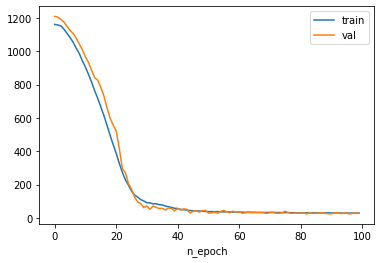

In [46]:
train_set = R_Net_Dataset(split=0)
val_set = R_Net_Dataset(split=1)

random.seed(1)
np.random.seed(1)
r_net = R_Net();
r_net.double()
loss_fn = nn.L1Loss()
batch_size, n_epoch, lr = 32, 100, 1e-3
train_size, val_size = 365, 365
argmin_loss = train(r_net, train_set, val_set, loss_fn, batch_size, lr, n_epoch, train_size, name='r_net')

In [47]:
r_net = R_Net();
r_net.double()
test_set = R_Net_Dataset(split=2)
test_loss = test(r_net, loss_fn, test_set, batch_size, lr, epoch=argmin_loss, name='r_net')
print("Test LOSS: \t%.4f" % (test_loss))

Test LOSS: 	31.4342


# R2-Net

[EP 	5] 		Train LOSS: 	1100.4062 		Val LOSS: 	1138.9765
[EP 	10] 		Train LOSS: 	937.8205 		Val LOSS: 	988.3635
[EP 	15] 		Train LOSS: 	713.6113 		Val LOSS: 	781.9939
[EP 	20] 		Train LOSS: 	444.3975 		Val LOSS: 	548.4485
[EP 	25] 		Train LOSS: 	184.9755 		Val LOSS: 	215.9262
[EP 	30] 		Train LOSS: 	86.4787 		Val LOSS: 	116.5345
[EP 	35] 		Train LOSS: 	64.1021 		Val LOSS: 	71.4140
[EP 	40] 		Train LOSS: 	53.6786 		Val LOSS: 	71.2460
[EP 	45] 		Train LOSS: 	53.0986 		Val LOSS: 	44.0467
[EP 	50] 		Train LOSS: 	49.5278 		Val LOSS: 	67.4587
[EP 	55] 		Train LOSS: 	49.5083 		Val LOSS: 	46.3323
[EP 	60] 		Train LOSS: 	42.3088 		Val LOSS: 	32.1615
[EP 	65] 		Train LOSS: 	40.8104 		Val LOSS: 	40.0495
[EP 	70] 		Train LOSS: 	41.5376 		Val LOSS: 	33.3969
[EP 	75] 		Train LOSS: 	40.0287 		Val LOSS: 	28.3666
[EP 	80] 		Train LOSS: 	36.7263 		Val LOSS: 	31.6204
[EP 	85] 		Train LOSS: 	38.3628 		Val LOSS: 	35.4703
[EP 	90] 		Train LOSS: 	35.9001 		Val LOSS: 	30.8748
[EP 	95] 		Train LOSS: 	35.6355 		

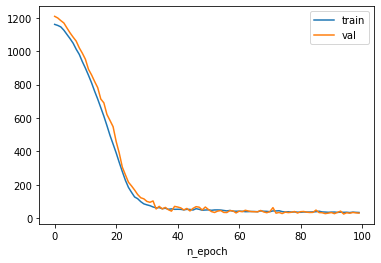

In [48]:
train_set = R_Net_Dataset(split=0)
val_set = R_Net_Dataset(split=1)

random.seed(1)
np.random.seed(1)
r2_net = R_Net(dropout=0.2, num_layers=2);
r2_net.double()
loss_fn = nn.L1Loss()
batch_size, n_epoch, lr = 32, 100, 1e-3
train_size, val_size = 365, 365
argmin_loss = train(r2_net, train_set, val_set, loss_fn, batch_size, lr, n_epoch, train_size, name='r2_net')

In [50]:
r2_net = R_Net(dropout=0.2, num_layers=2)
r2_net.double()
test_set = R_Net_Dataset(split=2)
test_loss = test(r2_net, loss_fn, test_set, batch_size, lr, epoch=argmin_loss, name='r2_net')
print("Test LOSS: \t%.4f" % (test_loss))

Test LOSS: 	34.6987


# RS-Net

[EP 	5] 		Train LOSS: 	1099.5063 		Val LOSS: 	1136.9226
[EP 	10] 		Train LOSS: 	938.4376 		Val LOSS: 	969.4300
[EP 	15] 		Train LOSS: 	733.5198 		Val LOSS: 	810.6500
[EP 	20] 		Train LOSS: 	508.8452 		Val LOSS: 	532.3726
[EP 	25] 		Train LOSS: 	287.1769 		Val LOSS: 	335.3711
[EP 	30] 		Train LOSS: 	172.8704 		Val LOSS: 	198.4338
[EP 	35] 		Train LOSS: 	108.1846 		Val LOSS: 	119.7678
[EP 	40] 		Train LOSS: 	84.3945 		Val LOSS: 	231.9498
[EP 	45] 		Train LOSS: 	72.6752 		Val LOSS: 	139.0408
[EP 	50] 		Train LOSS: 	64.3485 		Val LOSS: 	52.0260
[EP 	55] 		Train LOSS: 	55.9286 		Val LOSS: 	71.8962
[EP 	60] 		Train LOSS: 	50.7615 		Val LOSS: 	135.4758
[EP 	65] 		Train LOSS: 	44.3436 		Val LOSS: 	69.0160
[EP 	70] 		Train LOSS: 	44.8859 		Val LOSS: 	43.8206
[EP 	75] 		Train LOSS: 	44.1486 		Val LOSS: 	36.2841
[EP 	80] 		Train LOSS: 	40.2493 		Val LOSS: 	29.7997
[EP 	85] 		Train LOSS: 	41.3395 		Val LOSS: 	112.0350
[EP 	90] 		Train LOSS: 	39.8558 		Val LOSS: 	42.2047
[EP 	95] 		Train LOSS: 	38.

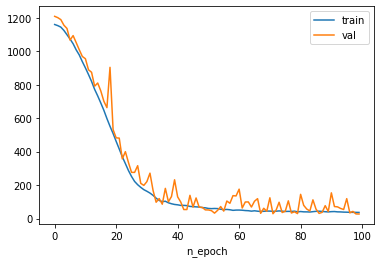

In [52]:
train_set = R_Net_Dataset(split=0)
val_set = R_Net_Dataset(split=1)

random.seed(1)
np.random.seed(1)
rs_net = R_Net(skip=True)
rs_net.double()
loss_fn = nn.L1Loss()
batch_size, n_epoch, lr = 32, 100, 1e-3
train_size, val_size = 365, 365
argmin_loss = train(rs_net, train_set, val_set, loss_fn, batch_size, lr, n_epoch, train_size, name='rs_net')

In [54]:
rs_net = R_Net(skip=True)
rs_net.double()
test_set = R_Net_Dataset(split=2)
test_loss = test(rs_net, loss_fn, test_set, batch_size, lr, epoch=argmin_loss, name='rs_net')
print("Test LOSS: \t%.4f" % (test_loss))

Test LOSS: 	31.6077


# RS2-Net

[EP 	5] 		Train LOSS: 	1100.3609 		Val LOSS: 	1130.9301
[EP 	10] 		Train LOSS: 	931.6741 		Val LOSS: 	952.9714
[EP 	15] 		Train LOSS: 	709.8076 		Val LOSS: 	725.1907
[EP 	20] 		Train LOSS: 	452.8340 		Val LOSS: 	441.4069
[EP 	25] 		Train LOSS: 	261.6612 		Val LOSS: 	265.8950
[EP 	30] 		Train LOSS: 	108.8949 		Val LOSS: 	117.8681
[EP 	35] 		Train LOSS: 	76.0873 		Val LOSS: 	66.1457
[EP 	40] 		Train LOSS: 	52.8254 		Val LOSS: 	53.7978
[EP 	45] 		Train LOSS: 	46.5708 		Val LOSS: 	111.4326
[EP 	50] 		Train LOSS: 	42.5364 		Val LOSS: 	89.9864
[EP 	55] 		Train LOSS: 	39.5245 		Val LOSS: 	32.8019
[EP 	60] 		Train LOSS: 	37.9169 		Val LOSS: 	85.9435
[EP 	65] 		Train LOSS: 	36.1555 		Val LOSS: 	28.4875
[EP 	70] 		Train LOSS: 	35.5334 		Val LOSS: 	48.9274
[EP 	75] 		Train LOSS: 	35.1671 		Val LOSS: 	51.6546
[EP 	80] 		Train LOSS: 	34.3743 		Val LOSS: 	27.5913
[EP 	85] 		Train LOSS: 	34.1235 		Val LOSS: 	35.8229
[EP 	90] 		Train LOSS: 	34.0043 		Val LOSS: 	38.8693
[EP 	95] 		Train LOSS: 	33.0606 

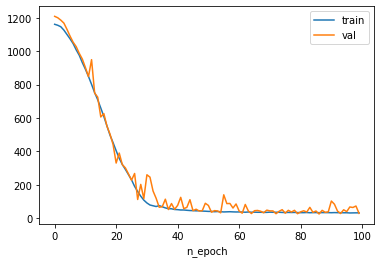

In [56]:
train_set = R_Net_Dataset(split=0)
val_set = R_Net_Dataset(split=1)

random.seed(1)
np.random.seed(1)
rs2_net = R_Net(dropout=0.2, num_layers=2, skip=True)
rs2_net.double()
loss_fn = nn.L1Loss()
batch_size, n_epoch, lr = 32, 100, 1e-3
train_size, val_size = 365, 365
argmin_loss = train(rs2_net, train_set, val_set, loss_fn, batch_size, lr, n_epoch, train_size, name='rs2_net')

In [57]:
rs2_net = R_Net(dropout=0.2, num_layers=2, skip=True)
rs2_net.double()
test_set = R_Net_Dataset(split=2)
test_loss = test(rs2_net, loss_fn, test_set, batch_size, lr, epoch=argmin_loss, name='rs2_net')
print("Test LOSS: \t%.4f" % (test_loss))

Test LOSS: 	30.8992


# Test Plot

In [ ]:
class Test_Dataset(Dataset):
    def __init__(self, eval_len=10, csv_dir='dataset/train.csv'):
        """
        Keyword arguments:
        split -- an integer either 0, 1, or 2 which indicates train, validation, or test respectively
        eval_len -- an integer indicating the number of future timestamp to be predicted
        """
        super(Test_Dataset, self).__init__()
        df = pd.read_csv(csv_dir)
        df['datetime']=pd.to_datetime(df['datetime'])
        df['week_day']=df['datetime'].dt.dayofweek
        df['hour']=df['datetime'].dt.hour
        df = df.drop(columns="datetime")
        data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
        self.data = np.array(data[2])
        self.eval_len = eval_len

    def __getitem__(self, idx):
        idx = np.random.randint(1, len(self.data)-1 - self.eval_len)
        prev_nat_demand = np.reshape(self.data[idx-1][0], -1)
        curr_feat = np.concatenate((prev_nat_demand, self.data[idx][1:]))
        curr_nat_demand = np.reshape(self.data[idx][0], -1)
        return curr_feat, curr_nat_demand

    def __len__(self):
        return len(self.data)

In [ ]:
@torch.no_grad()
def test_plot(net, loss_fn, test_data, batch_size, lr, epoch=90, name='net', num_plot=0):
    net.eval()
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    save_dir = f'drive/MyDrive/COMP4211/project/logs/{name}_{batch_size}_{lr}'
    net.load_state_dict(torch.load(osp.join(save_dir, 'weights/ep%d.pth' % epoch)))
    test_loader = DataLoader(test_set, batch_size=1)
    ep_loss = 0.0
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(test_loader):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
        if n_iter == num_plot:
            break
    ep_loss /= len(test_loader)
    return ep_loss

# MB_Net

In [ ]:
class MB_Net_Dataset(Dataset):
    def __init__(self, split, eval_len=1, mb_len=5, window_size=5, csv_dir='dataset/train.csv'):
        """
        Keyword arguments:
        split -- an integer either 0, 1, or 2 which indicates train, validation, or test respectively
        eval_len -- an integer indicating the number of future timestamp to be predicted
        """
        super(MB_Net_Dataset, self).__init__()
        df = pd.read_csv(csv_dir)
        df['datetime']=pd.to_datetime(df['datetime'])
        df['week_day']=df['datetime'].dt.dayofweek
        # df['date']=df['datetime'].dt.day
        # df['month']=df['datetime'].dt.month
        df['hour']=df['datetime'].dt.hour
        df = df.drop(columns="datetime")
        data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
        self.data = np.array(data[split])
        self.eval_len = eval_len
        self.window_size = window_size
        self.mb_len = mb_len

    def __getitem__(self, idx):
        min_start = 1 + self.window_size + self.mb_len
        max_start = len(self.data)-1 - self.eval_len
        idx = np.random.randint(min_start, max_start)
        prev_nat_demand = np.reshape(self.data[idx-1 - self.window_size - self.mb_len: idx-1, 0], (-1,1))
        curr_feat = np.concatenate((prev_nat_demand, self.data[idx - self.window_size - self.mb_len: idx, 1:]), axis=1)
        curr_nat_demand = np.reshape(self.data[idx, 0], -1)
        return torch.tensor(curr_feat, dtype=torch.float64), torch.tensor(curr_nat_demand, dtype=torch.float64)

    def __len__(self):
        return len(self.data)

a = MB_Net_Dataset(split=0)
for i, (x,y) in enumerate(DataLoader(a, batch_size=1)):
    print(x.shape)
    print(y.shape)
    break

torch.Size([1, 25, 18])
torch.Size([1, 1])


In [ ]:
class MB_Net(nn.Module):
    def __init__(self, input_size=18, hidden_size=32, dropout=0, num_layers=1):
        super(R_Net, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc1 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU(inplace=True)
 
    def forward(self, x):
        x, _ = self.lstm(x.double())
        x = self.fc1(x[:,-1])
        x = self.relu(x)
        
        return x